<a href="http://agrum.org" target="blank"><img src="http://agrum.gitlab.io/theme/img/logoAgrum.png" align="left" style="height:100px"/></a><a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This pyAgrum's notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

In [1]:
%load_ext autoreload
%autoreload 2

import os

%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
from IPython.core.display import display,HTML

import math

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

# Build a decision diagram

## fast build with string

In [3]:
gum.fastID("A->*B->$C<-D<-*E->*G->H->*I<-D")

(gum::InfluenceDiagram<double>@000001EFDFA20BD0) Influence Diagram{
  chance: 3,
  utility: 1,
  decision: 4,
  arcs: 8,
  domainSize: 128
}

## bifxml format file

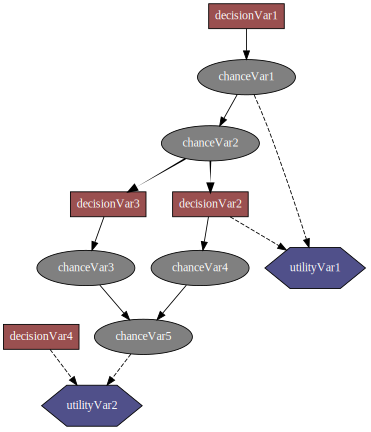

In [4]:
diag=gum.loadID(os.path.join("res","diag.bifxml"))
gnb.showInfluenceDiagram(diag)

In [5]:
diag

(gum::InfluenceDiagram<double>@000001EFFF0A1340) Influence Diagram{
  chance: 5,
  utility: 2,
  decision: 4,
  arcs: 12,
  domainSize: 512
}

## the hard way :-)

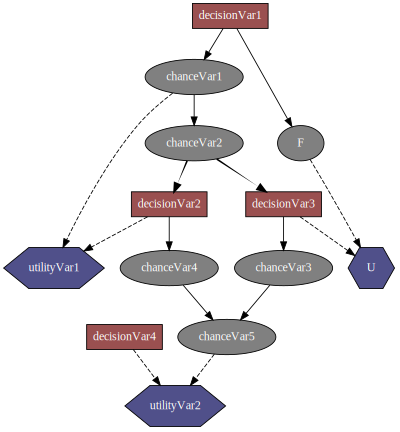

In [6]:
F=diag.addChanceNode(gum.LabelizedVariable("F","F",2))
diag.addArc(diag.idFromName("decisionVar1"),F)

U=diag.addUtilityNode(gum.LabelizedVariable("U","U",1))
diag.addArc(diag.idFromName("decisionVar3"),U)
diag.addArc(diag.idFromName("F"),U)
gnb.showInfluenceDiagram(diag)

In [7]:
diag.cpt(F)[{'decisionVar1':0}]=[0.9,0.1]
diag.cpt(F)[{'decisionVar1':1}]=[0.3,0.7]

diag.utility(U)[{'F':0,'decisionVar3':0}]=2
diag.utility(U)[{'F':0,'decisionVar3':1}]=4
diag.utility(U)[{'F':1}]=[[0],[5]]

# Optimization in an influence diagram (actually LIMID)

In [8]:
oil=gum.loadID(os.path.join("res","OilWildcatter.bifxml"))
gnb.sideBySide(oil,gnb.getInference(oil))

In [9]:
# a function to show results on decision nodes T and D
def show_decisions(ie):
    gnb.sideBySide(ie.optimalDecision("Testing"),
                   ie.optimalDecision("Drilling"),
                   f"{ie.MEU()['mean']:5.3f} (stdev : {math.sqrt(ie.MEU()['variance']):5.3f})",
                   captions=["Strategy for T","Strategy for D","MEU and its standard deviation>"])
    gnb.sideBySide(ie.posterior("Testing"),ie.posteriorUtility("Testing"),ie.posterior("Drilling"),ie.posteriorUtility("Drilling"),
                  captions=["Final decision for Testing","Final reward for Testing","Final decision for Drilling","Final reward for Drilling"])

ie=gum.ShaferShenoyLIMIDInference(oil) 

display(HTML("<h2>Inference in the LIMID optimizing the decisions nodes</h2>"))
ie.makeInference()
show_decisions(ie)

# Graphical inference with evidence and targets (developped nodes)

In [10]:
gnb.sideBySide(oil,gnb.getInference(oil,evs={'TestResult':'closed'}),gnb.getInference(oil,evs={'TestResult':'open'}),gnb.getInference(oil,evs={'TestResult':'diffuse'}))
gnb.sideBySide(oil,gnb.getInference(oil,evs={'OilContents':'Dry'}),gnb.getInference(oil,evs={'OilContents':'Wet'}),gnb.getInference(oil,evs={'OilContents':'Soaking'}))

## Soft evidence on chance node

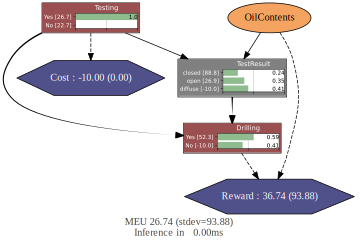

In [11]:
gnb.showInference(oil,evs={'OilContents':[0.7,0.5,0.8]},targets={'Testing','Drilling','TestResult'})

## Forced decision

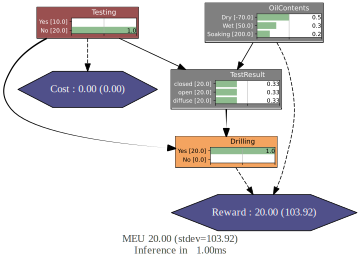

In [12]:
gnb.showInference(oil,evs={'Drilling':'Yes'})

## LIMID versus Influence Diagram

The default inference for influence diagram actually an inference for LIMIDs. In order to use it for classical (and solvable) influence diagram, do not forget to add the sequence of decision nodes using `addNoForgettingAssumption`.

In [22]:
infdiag=gum.fastID("Chance->*Decision1->Chance2->$Utility<-Chance3<-*Decision2<-Chance->Utility")
infdiag

(gum::InfluenceDiagram<double>@000001EFFF4CFEA0) Influence Diagram{
  chance: 3,
  utility: 1,
  decision: 2,
  arcs: 7,
  domainSize: 32
}

In [23]:
ie=gum.ShaferShenoyLIMIDInference(infdiag)
try:
    ie.makeInference()
except gum.GumException as e:
    print(e)

[pyAgrum] Fatal error: This LIMID/Influence Diagram is not solvable.


In [24]:
ie.addNoForgettingAssumption(["Decision1","Decision2"])
gnb.sideBySide(ie.reducedLIMID(),ie.junctionTree(),gnb.getInference(infdiag,ie))

InfluenceDiagram <!-- Chance-Chance2-Decision1-Decision2 --> Chance-Chance2-Decision1-Decision2 Chance Chance2 Decision1 Decision2 <!-- Chance-Chance2-Decision1-Decision2+Chance-Chance2-Chance3-Decision2 --> Chance-Chance2-Decision1-Decision2+Chance-Chance2-Chance3-Decision2 Chance Chance2 Decision2 <!-- Chance-Chance2-Decision1-Decision2--Chance-Chance2-Decision1-Decision2+Chance-Chance2-Chance3-Decision2 --> Chance-Chance2-Decision1-Decision2--Chance-Chance2-Decision1-Decision2+Chance-Chance2-Chance3-Decision2 <!-- Chance-Chance2-Chance3-Decision2 --> Chance-Chance2-Chance3-Decision2 Chance Chance2 Chance3 Decision2 <!-- Chance-Chance2-Decision1-Decision2+Chance-Chance2-Chance3-Decision2--Chance-Chance2-Chance3-Decision2 --> Chance-Chance2-Decision1-Decision2+Chance-Chance2-Chance3-Decision2--Chance-Chance2-Chance3-Decision2
